<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6001 entries, 0 to 6000
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             6001 non-null   int64  
 1   patient_race                           3063 non-null   object 
 2   payer_type                             5174 non-null   object 
 3   patient_state                          5979 non-null   object 
 4   patient_zip3                           6001 non-null   int64  
 5   patient_age                            6001 non-null   int64  
 6   patient_gender                         6001 non-null   object 
 7   bmi                                    1814 non-null   float64
 8   breast_cancer_diagnosis_code           6001 non-null   object 
 9   breast_cancer_diagnosis_desc           6001 non-null   object 
 10  metastatic_cancer_diagnosis_code       6001 non-null   object 
 11  meta

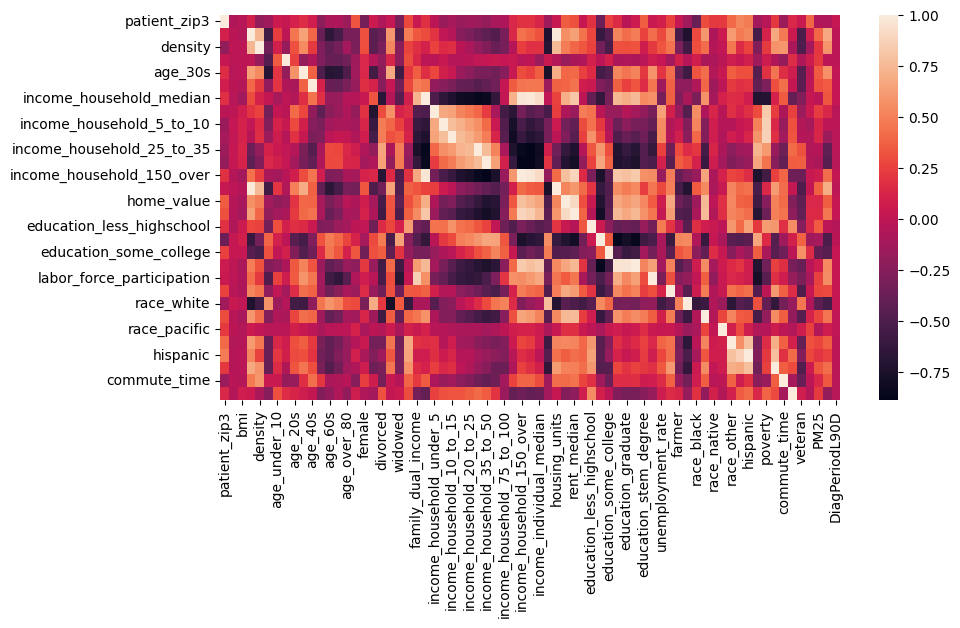

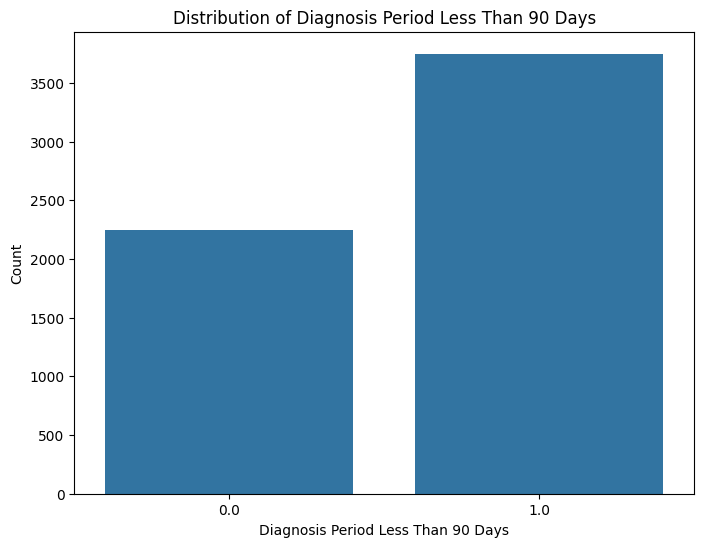

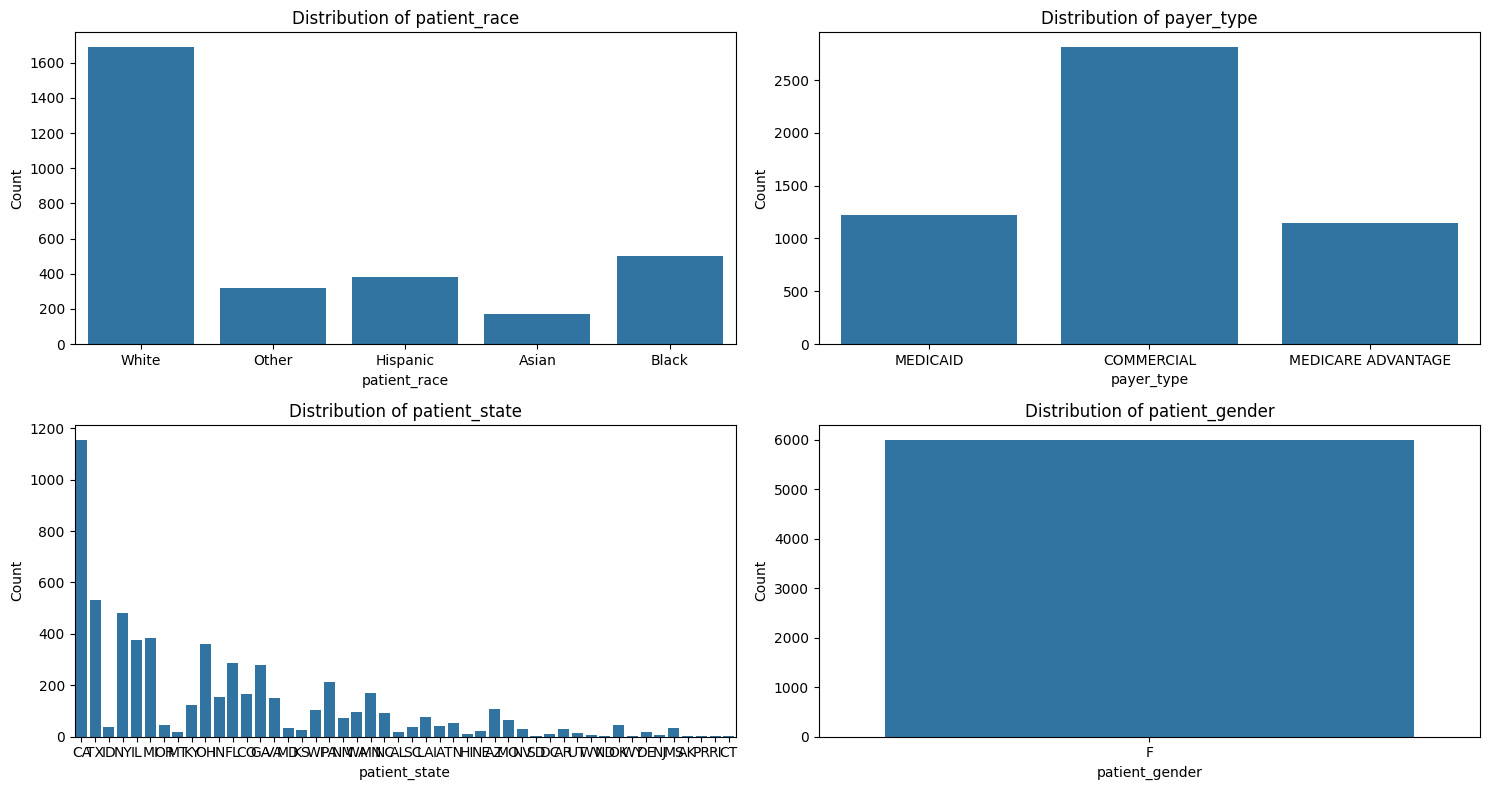

<ipython-input-1-1ec905646944>:63: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_data.corr()


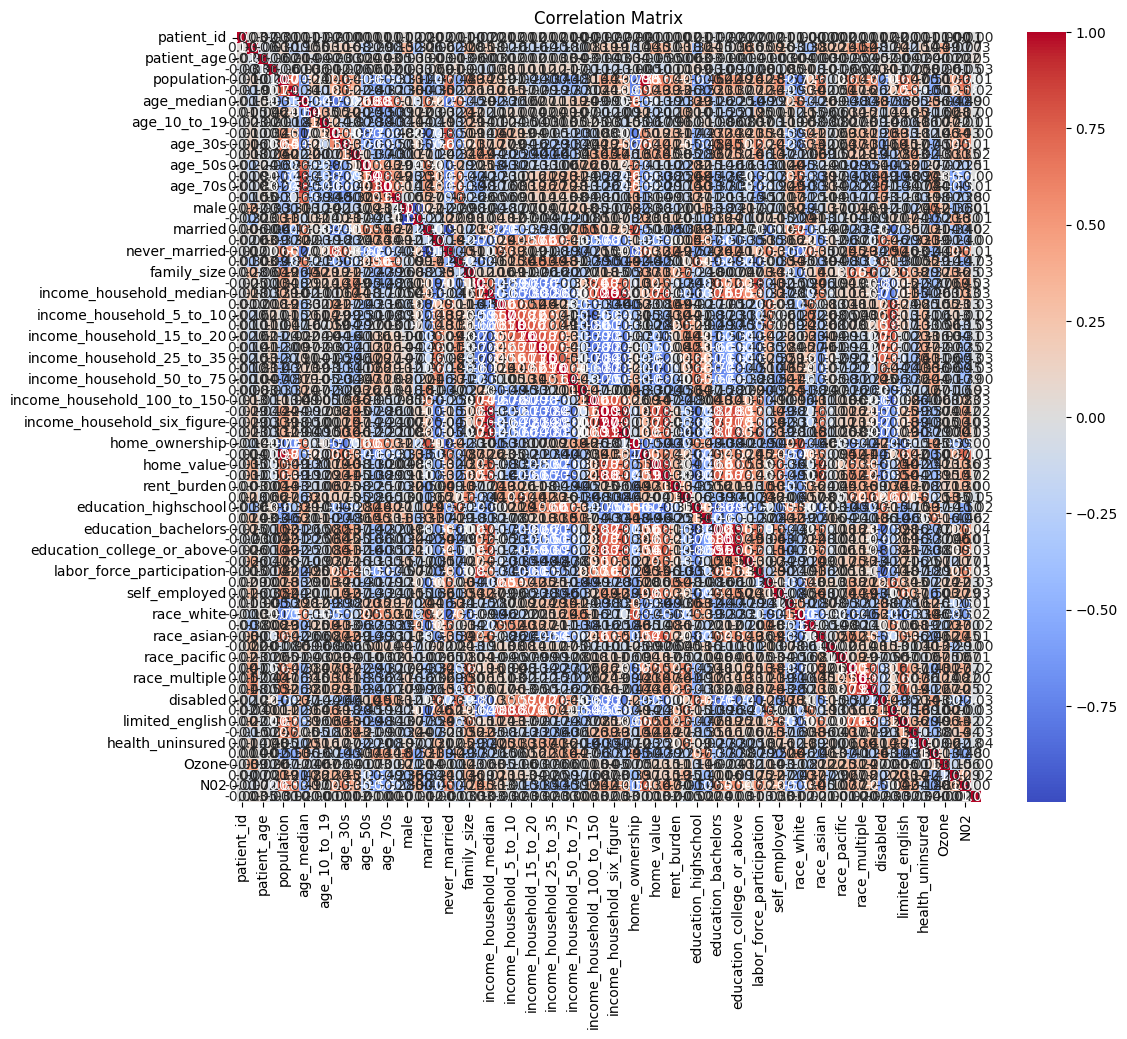

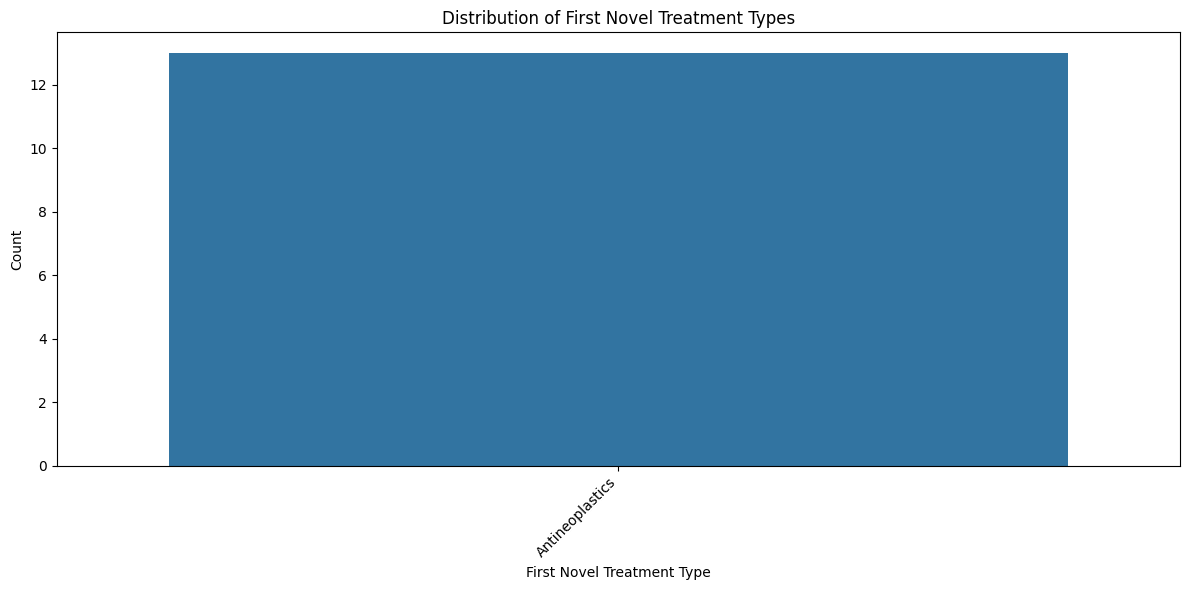

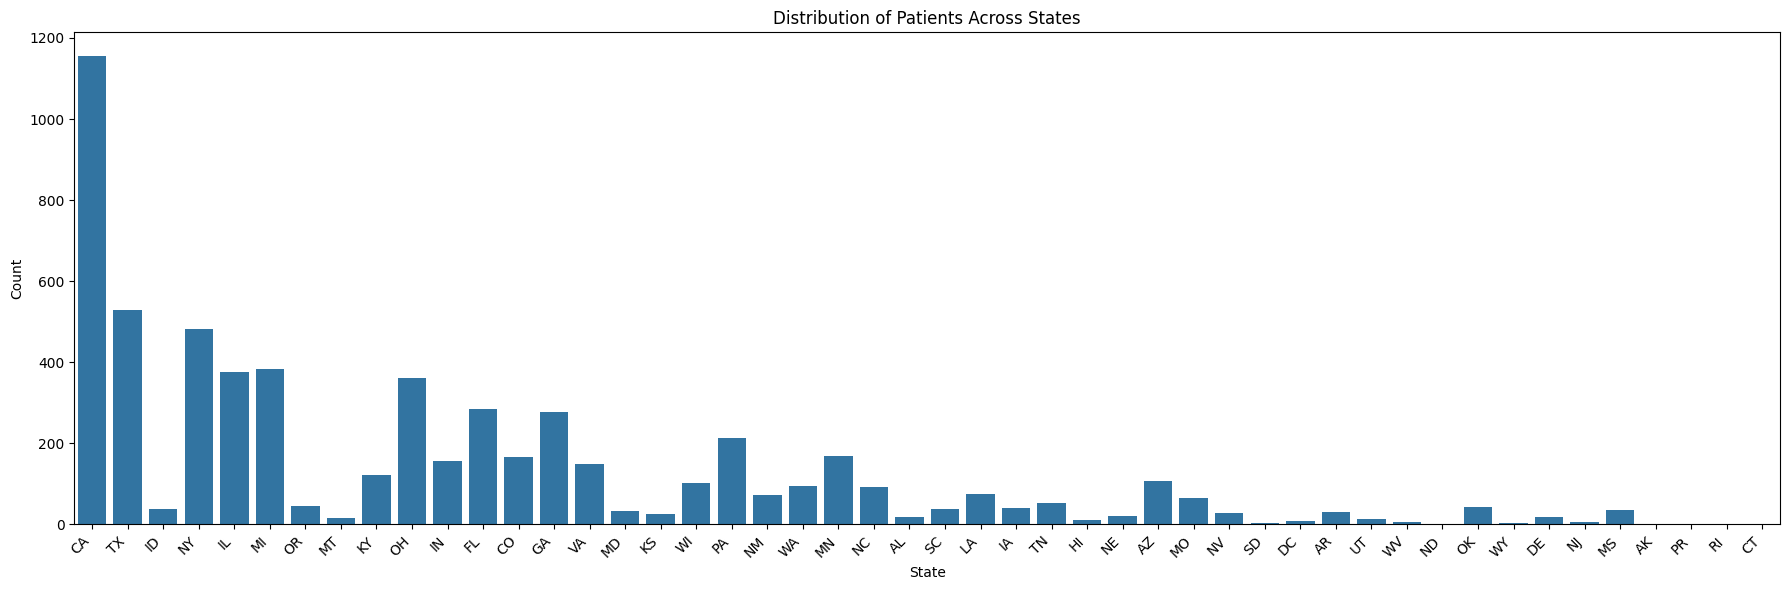

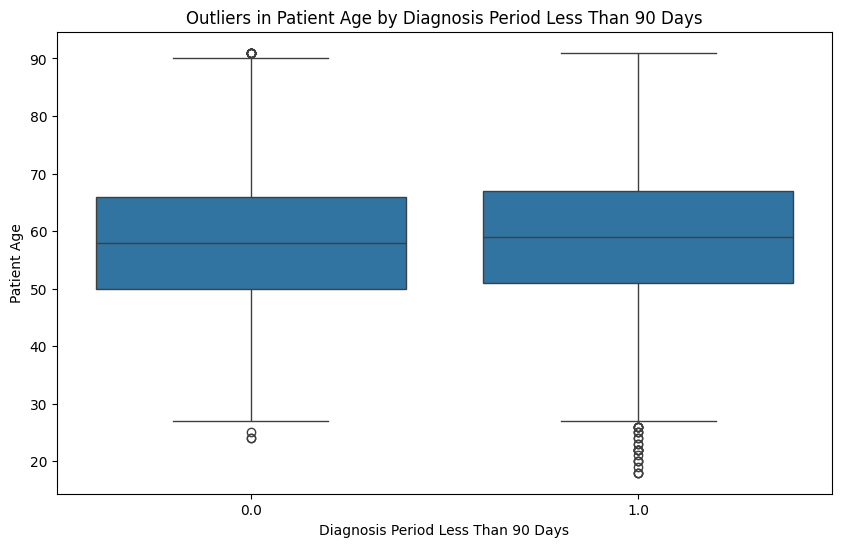

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Data
train_data = pd.read_csv('training.csv')

# Display basic information about the dataset
print(train_data.info())

# Summary Statistics
print(train_data.describe())

# Check Missing Values
print(train_data.isnull().sum())


corr_df = train_data.drop(['patient_id'],axis=1).select_dtypes(exclude='object').corr()

# only looking at correlations showing a coefficient higher than 0.01
corr_df = corr_df[abs(corr_df)>0.005].dropna(how='any',axis=0)
corr_df = corr_df[abs(corr_df)>0.005].dropna(how='any',axis=1)

plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df)

# Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x='DiagPeriodL90D', data=train_data)
plt.title('Distribution of Diagnosis Period Less Than 90 Days')
plt.xlabel('Diagnosis Period Less Than 90 Days')
plt.ylabel('Count')
plt.show()

# Explore Categorical Variables
categorical_variables = ['patient_race', 'payer_type', 'patient_state', 'patient_gender']
plt.figure(figsize=(15, 8))
for i, variable in enumerate(categorical_variables, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=variable, data=train_data)
    plt.title(f'Distribution of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# # Explore Numeric Variables
# numeric_variables = ['patient_age', 'income_household_median', 'ozone']
# plt.figure(figsize=(15, 4))
# for i, variable in enumerate(numeric_variables, 1):
#     plt.subplot(1, 3, i)
#     sns.histplot(train_data[variable], bins=30, kde=True)
#     plt.title(f'Distribution of {variable}')
#     plt.xlabel(variable)
#     plt.ylabel('Count')
# plt.tight_layout()
# plt.show()

# Correlation Analysis
correlation_matrix = train_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Explore Time-Related Variables
plt.figure(figsize=(12, 6))
sns.countplot(x='metastatic_first_novel_treatment_type', data=train_data)
plt.title('Distribution of First Novel Treatment Types')
plt.xlabel('First Novel Treatment Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Geographic Analysis
plt.figure(figsize=(18, 6))
sns.countplot(x='patient_state', data=train_data)
plt.title('Distribution of Patients Across States')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# # Toxic Air Quality Analysis
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x='ozone', y='PM25', hue='DiagPeriodL90D', data=train_data)
# plt.title('Toxic Air Quality vs. Diagnosis Period Less Than 90 Days')
# plt.xlabel('Ozone')
# plt.ylabel('PM2.5')
# plt.legend(title='Diagnosis Period Less Than 90 Days', loc='upper right', labels=['No', 'Yes'])
# plt.show()

# Feature Engineering (if needed)
# Outlier Detection and Handling
plt.figure(figsize=(10, 6))
sns.boxplot(x='DiagPeriodL90D', y='patient_age', data=train_data)
plt.title('Outliers in Patient Age by Diagnosis Period Less Than 90 Days')
plt.xlabel('Diagnosis Period Less Than 90 Days')
plt.ylabel('Patient Age')
plt.show()


# Save the Cleaned Data
# train_data.to_csv('cleaned_train_data.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

train_data = pd.read_csv("training.csv")

# Drop unnecessary columns
train_data = train_data.drop(['patient_id'], axis=1)

# Handle missing values and encode categorical variables using one-hot encoding
train_data = pd.get_dummies(train_data, columns=['patient_race', 'payer_type', 'patient_state', 'patient_gender',
                                                 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
                                                 'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
                                                 'metastatic_first_novel_treatment_type', 'Region', 'Division'])

# Split the data into features (X) and target variable (y)
X = train_data.drop(columns=["DiagPeriodL90D"])
y = train_data["DiagPeriodL90D"]

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose a classification model (XGBoost)
model = xgb.XGBClassifier(random_state=42)

# Train the XGBoost model
model.fit(X_train, y_train)

# Get feature importances
feature_importance = model.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top N important features
top_n_features = 10
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n_features))
plt.title(f'Top {top_n_features} Important Features')
plt.show()

# Extract the top N important features
top_features = feature_importance_df.head(top_n_features)['Feature'].tolist()

# Select only the top features for correlation analysis
selected_features = X_train[top_features]

# Calculate correlations among the selected features
corr_df = selected_features.corr()

# Visualize the correlations using a heatmap
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title('Correlation Heatmap of Top Important Features')
plt.show()


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [ 0.  1. nan]

# **Univariate Feature Selection**:

SelectKBest: Select the top k features based on univariate statistical tests.
SelectPercentile: Select the top features based on a percentage of the highest scores.


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd

# Load your data (replace 'your_dataset.csv' with your actual dataset)
train_data = pd.read_csv("training.csv")

# Drop the patient_id column
train_data = train_data.drop(['patient_id'], axis=1)

# Handle missing values
# Separate numerical and categorical features
numerical_features = train_data.select_dtypes(include=['float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns

# Impute missing values for numerical features
numerical_imputer = SimpleImputer(strategy='mean')
train_data[numerical_features] = numerical_imputer.fit_transform(train_data[numerical_features])

# Impute missing values for categorical features
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_data[categorical_features] = categorical_imputer.fit_transform(train_data[categorical_features])

# One-hot encode categorical variables
train_data = pd.get_dummies(train_data, columns=categorical_features)

# Split the data into features (X) and target variable (y)
X = train_data.drop(columns=["DiagPeriodL90D"])
y = train_data["DiagPeriodL90D"]

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# SelectKBest with ANOVA F-statistic as the score function (for classification problems)
k = 10
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

# Create a DataFrame with selected features
selected_features_df = pd.DataFrame(X_train_selected, columns=selected_feature_names)

# Print the names of selected features
print("Selected Features:")
print(selected_feature_names)


Selected Features:
Index(['breast_cancer_diagnosis_code_1744',
       'breast_cancer_diagnosis_code_1748',
       'breast_cancer_diagnosis_code_1749',
       'breast_cancer_diagnosis_code_C50911',
       'breast_cancer_diagnosis_code_C50912',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of breast (female), unspecified',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of other specified sites of female breast',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of unsp site of right female breast',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of unspecified site of left female breast',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of upper-outer quadrant of female breast'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [128 153 162 205 207 254 274] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


# **Recursive Feature Elimination (RFE)**:

RFE recursively removes the least important features based on a model's feature weights.


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Load your data (replace 'your_dataset.csv' with your actual dataset)
train_data = pd.read_csv("training.csv")

# Drop the patient_id column
train_data = train_data.drop(['patient_id'], axis=1)

# Handle missing values
# Separate numerical and categorical features
numerical_features = train_data.select_dtypes(include=['float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns

# Impute missing values for numerical features
numerical_imputer = SimpleImputer(strategy='mean')
train_data[numerical_features] = numerical_imputer.fit_transform(train_data[numerical_features])

# Impute missing values for categorical features
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_data[categorical_features] = categorical_imputer.fit_transform(train_data[categorical_features])

# One-hot encode categorical variables
train_data = pd.get_dummies(train_data, columns=categorical_features)

# Split the data into features (X) and target variable (y)
X = train_data.drop(columns=["DiagPeriodL90D"])
y = train_data["DiagPeriodL90D"]

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a base classifier (you can use any other classifier of your choice)
base_classifier = RandomForestClassifier()

# Create the RFE model and select 10 features
n_features_to_select = 10
rfe = RFE(estimator=base_classifier, n_features_to_select=n_features_to_select)
X_train_rfe = rfe.fit_transform(X_train, y_train)

# Get the names of the selected features
selected_feature_names = X_train.columns[rfe.support_]

# Create a DataFrame with selected features
selected_features_df = pd.DataFrame(X_train_rfe, columns=selected_feature_names)

# Print the names of selected features
print("Selected Features:")
print(selected_feature_names)


Selected Features:
Index(['patient_zip3', 'patient_age', 'bmi', 'age_over_80', 'widowed',
       'income_household_75_to_100', 'unemployment_rate', 'commute_time',
       'breast_cancer_diagnosis_code_1749',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of breast (female), unspecified'],
      dtype='object')


LASSO Regression:

L1 regularization (LASSO) can be used to encourage sparsity in feature weights, effectively performing feature selection.


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load your data (replace 'your_dataset.csv' with your actual dataset)
train_data = pd.read_csv("training.csv")

# Drop the patient_id column
train_data = train_data.drop(['patient_id'], axis=1)

# Handle missing values
# Separate numerical and categorical features
numerical_features = train_data.select_dtypes(include=['float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns

# Impute missing values for numerical features
numerical_imputer = SimpleImputer(strategy='mean')
train_data[numerical_features] = numerical_imputer.fit_transform(train_data[numerical_features])

# Impute missing values for categorical features
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_data[categorical_features] = categorical_imputer.fit_transform(train_data[categorical_features])

# One-hot encode categorical variables
train_data = pd.get_dummies(train_data, columns=categorical_features)

# Split the data into features (X) and target variable (y)
X = train_data.drop(columns=["DiagPeriodL90D"])
y = train_data["DiagPeriodL90D"]

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Create the Lasso model
lasso = Lasso(alpha=0.04)  # Adjust the alpha parameter based on the desired level of regularization

# Fit the model to the training data
lasso.fit(X_train_scaled, y_train)

# Get the coefficients of the features
feature_coefficients = pd.Series(lasso.coef_, index=X.columns)

# Get the names of non-zero coefficient features (selected features)
selected_feature_names = feature_coefficients[feature_coefficients != 0].index

# Print the names of selected features
print("Selected Features:")
print(selected_feature_names)


Selected Features:
Index(['breast_cancer_diagnosis_code_1741',
       'breast_cancer_diagnosis_code_1742',
       'breast_cancer_diagnosis_code_1744',
       'breast_cancer_diagnosis_code_1745',
       'breast_cancer_diagnosis_code_1748',
       'breast_cancer_diagnosis_code_1749',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of breast (female), unspecified',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of central portion of female breast',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of lower-outer quadrant of female breast',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of other specified sites of female breast',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of upper-inner quadrant of female breast',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of upper-outer quadrant of female breast'],
      dtype='object')


# Tree-based Methods:

Decision trees and tree-based models can be analyzed for feature importance.

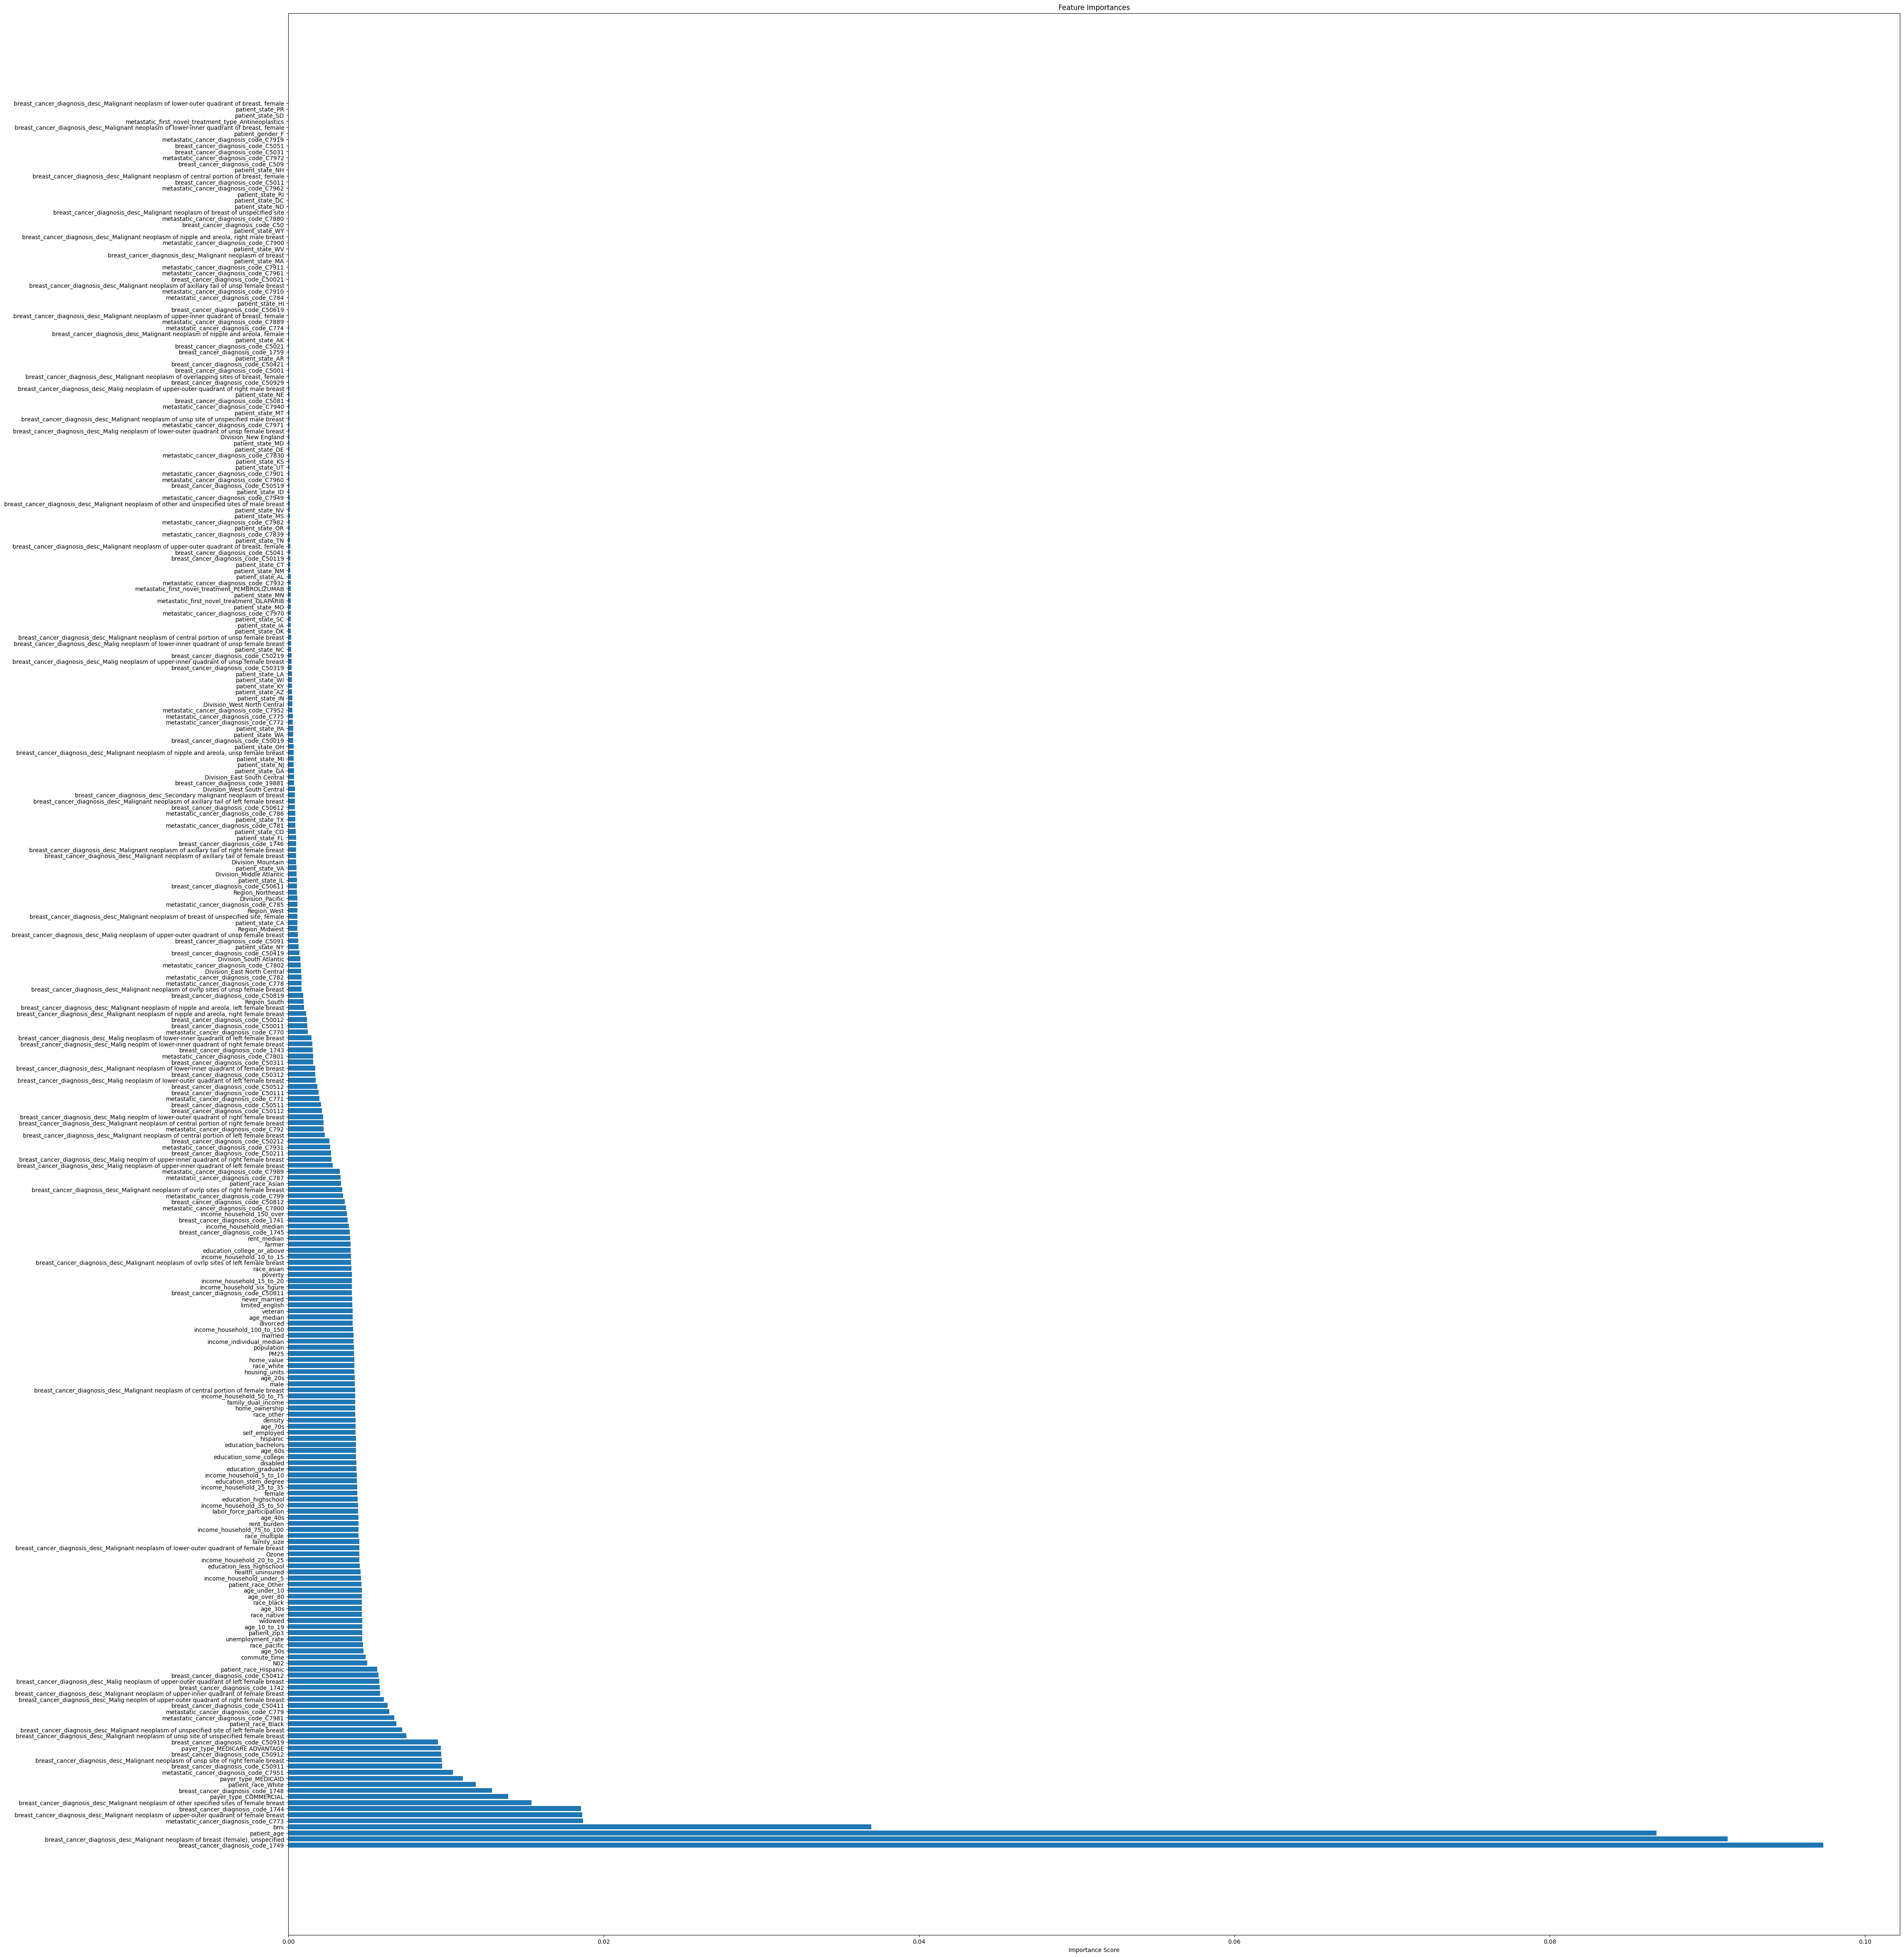

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (replace 'your_dataset.csv' with your actual dataset)
train_data = pd.read_csv("training.csv")

# Drop the patient_id column
train_data = train_data.drop(['patient_id'], axis=1)

# Handle missing values
# Separate numerical and categorical features
numerical_features = train_data.select_dtypes(include=['float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns

# Impute missing values for numerical features
numerical_imputer = SimpleImputer(strategy='mean')
train_data[numerical_features] = numerical_imputer.fit_transform(train_data[numerical_features])

# Impute missing values for categorical features
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_data[categorical_features] = categorical_imputer.fit_transform(train_data[categorical_features])

# One-hot encode categorical variables
train_data = pd.get_dummies(train_data, columns=categorical_features)

# Split the data into features (X) and target variable (y)
X = train_data.drop(columns=["DiagPeriodL90D"])
y = train_data["DiagPeriodL90D"]

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Get the names of features
feature_names = X_train.columns

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(50, 60))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importances')
plt.show()


Number of missing values in BMI column: 8965


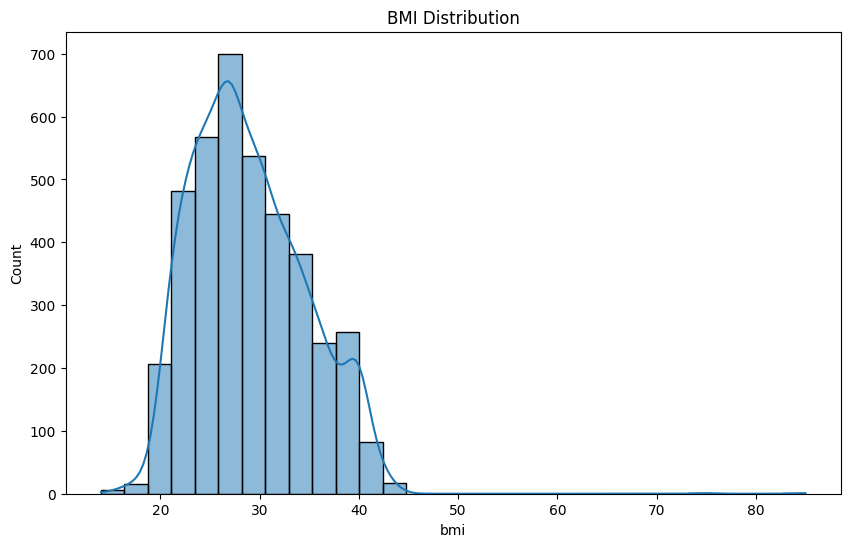


Summary Statistics:
count    3941.000000
mean       28.984539
std         5.696906
min        14.000000
25%        24.660000
50%        28.190000
75%        32.920000
max        85.000000
Name: bmi, dtype: float64

Correlation with BMI:
bmi                            1.000000
income_household_35_to_50      0.095446
income_household_25_to_35      0.094422
education_highschool           0.090453
income_household_20_to_25      0.088759
                                 ...   
home_value                    -0.090552
rent_median                   -0.097696
income_household_median       -0.104458
income_household_150_over     -0.104607
income_household_six_figure   -0.106262
Name: bmi, Length: 72, dtype: float64


<ipython-input-4-2aec679ecbc8>:25: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


0             Obese
1        Overweight
2             Obese
3             Obese
4             Obese
            ...    
12901         Obese
12902         Obese
12903    Overweight
12904         Obese
12905         Obese
Name: bmi_category, Length: 12906, dtype: object

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Data
df = pd.read_csv('training.csv')
bmi_column = df['bmi']

# 1. Missing Values
missing_values = bmi_column.isnull().sum()
print(f"Number of missing values in BMI column: {missing_values}")

# 2. Distribution
plt.figure(figsize=(10, 6))
sns.histplot(bmi_column.dropna(), bins=30, kde=True)
plt.title('BMI Distribution')
plt.show()

# 3. Summary Statistics
summary_stats = bmi_column.describe()
print("\nSummary Statistics:")
print(summary_stats)

# 4. Correlation with Other Features
correlation_matrix = df.corr()
bmi_correlation = correlation_matrix['bmi'].sort_values(ascending=False)
print("\nCorrelation with BMI:")
print(bmi_correlation)

# 5. BMI Categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal Weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df['bmi_category'] = df['bmi'].apply(categorize_bmi)

df['bmi_category']

<ipython-input-51-1878fe8df327>:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


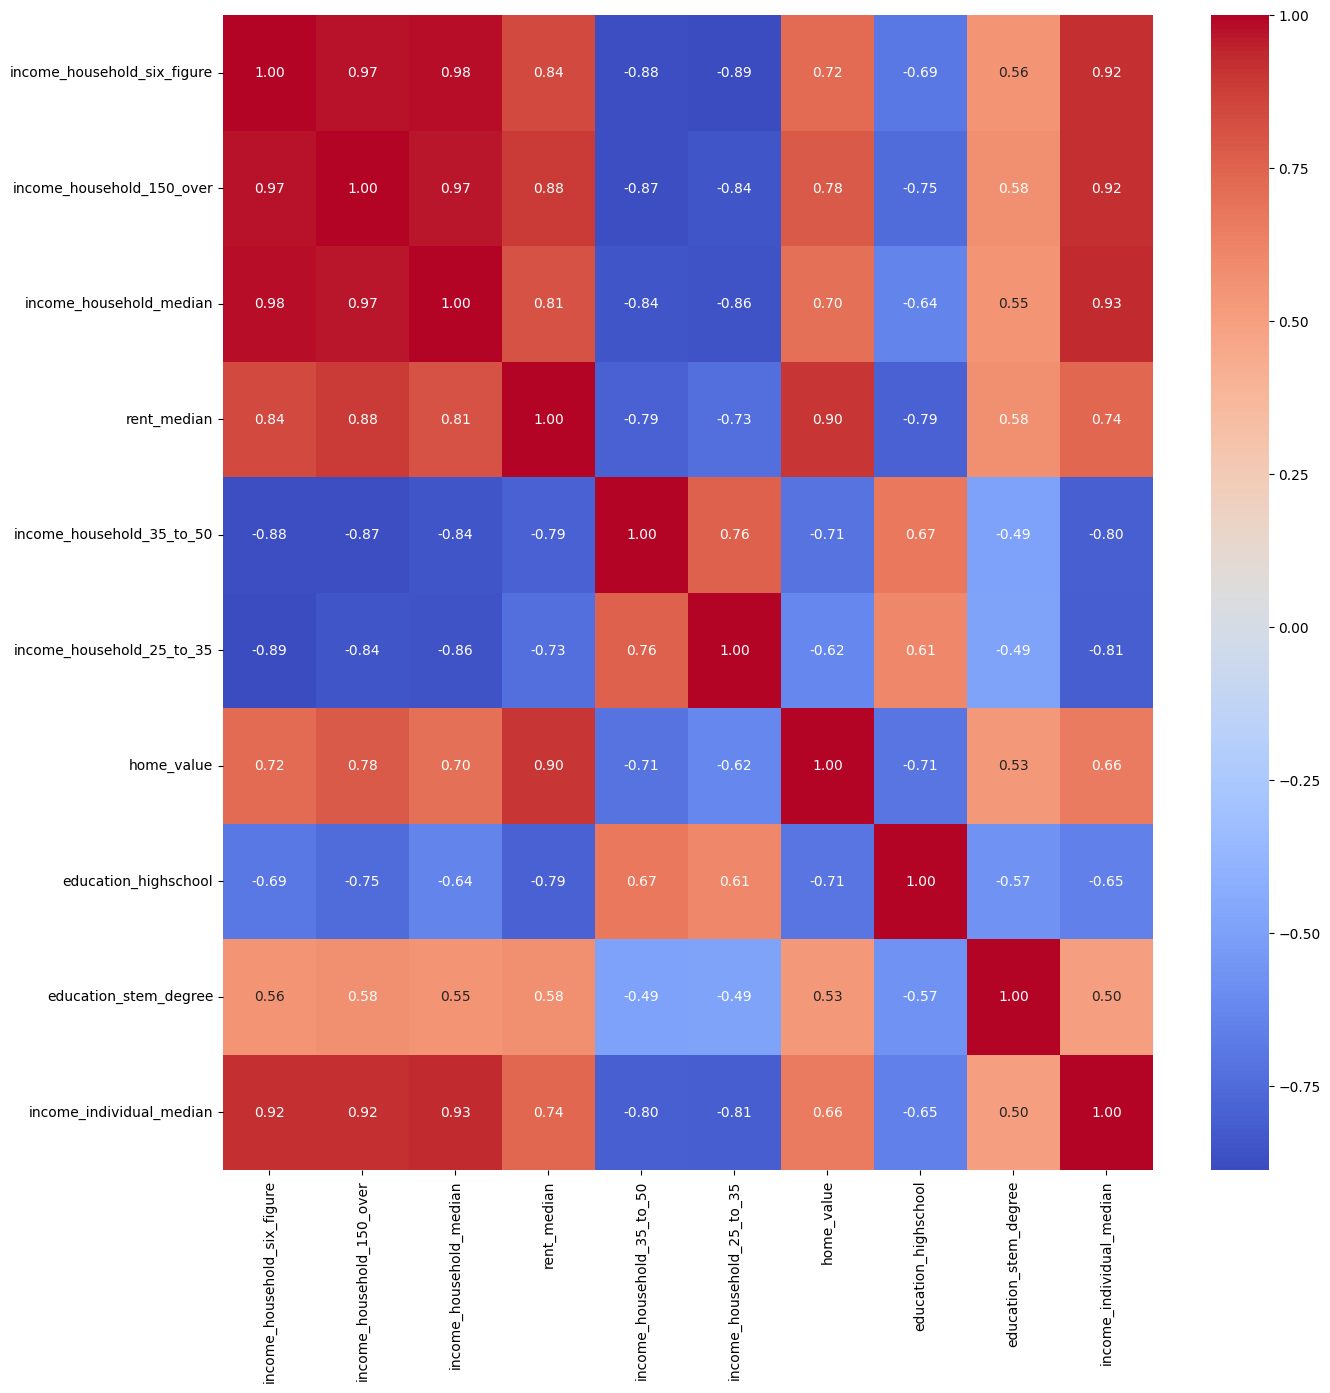

8965
Top Col:  Index(['income_household_six_figure', 'income_household_150_over',
       'income_household_median', 'rent_median', 'income_household_35_to_50',
       'income_household_25_to_35', 'home_value', 'education_highschool',
       'education_stem_degree', 'income_individual_median'],
      dtype='object')
         bmi  bmi_filled
0        NaN   30.098605
1      28.49         NaN
2      38.09         NaN
3        NaN   27.445879
4        NaN   26.759150
...      ...         ...
12901  32.11         NaN
12902    NaN   26.339675
12903  29.24         NaN
12904  31.00         NaN
12905    NaN   31.410955

[12906 rows x 2 columns]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

# Load the Data
df = pd.read_csv('training.csv')

correlation_matrix = df.corr()

# Get the top 10 columns with the highest absolute correlation with 'bmi'
top_columns = correlation_matrix['bmi'].abs().sort_values(ascending=False).head(11).index[1:]

# Plot the heatmap for the top 10 columns
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix[top_columns].loc[top_columns], annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

print(df['bmi'].isnull().sum())

print("Top Col: ", top_columns)

# Assuming X contains features and y contains BMI
X = df[top_columns]
y = df['bmi']

# Identify rows with missing 'bmi' values
missing_bmi_mask = y.isnull()

# Separate the dataframe into features (X_train) and target (y_train) for non-missing values
X_train, y_train = X[~missing_bmi_mask], y[~missing_bmi_mask]

# Identify numerical columns
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Create transformers for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # You can choose another strategy
])

# Use ColumnTransformer to apply the numerical transformer to the numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
    ])

# Build the model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor())])

# Train the model on the rows where 'bmi' is not missing
model.fit(X_train, y_train)

# Predict missing 'bmi' values in the entire dataset
predicted_bmi = model.predict(X[missing_bmi_mask])

# Fill missing 'bmi' values with predictions
df.loc[missing_bmi_mask, 'bmi_filled'] = predicted_bmi

# Print the original 'bmi' and the new 'bmi_filled' columns
print(df[['bmi', 'bmi_filled']])

# Create a new column 'merged_bmi' with the merged output of 'bmi' and 'bmi_filled'
df['merged_bmi'] = df.apply(lambda row: row['bmi_filled'] if pd.notnull(row['bmi_filled']) else row['bmi'], axis=1)

df.to_csv('training_bmi.csv', index=False)
